# Flower Detection using Transfer Learning
In this assignment we will use transfer learning to detect if there is a human in a given image. We will use a pre-trained model (MobileNet-V2), which was trained on ImageNet dataset and use a [Kaggle human detection dataset](https://www.kaggle.com/datasets/jessijha/ese3600-flowers).

**Acknowledgements**

This colab is heavily borrowed from the [Google's Transfer learning](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb) Colab and [EdX TinyML course's](https://github.com/tinyMLx) Mask Detection Colab.


In [1]:
!pip install -U tf_keras  &> 0 # Keras 2
!pip install kagglehub

import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory


# Suppress only PNG warnings
tf.get_logger().setLevel('ERROR')

RunningInCOLAB = 'google.colab' in str(get_ipython())

## Build the dataset

### Download the dataset

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessijha/ese3600-flowers")
print("Path to dataset files:", path)

100%|██████████| 440M/440M [00:20<00:00, 22.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jessijha/ese3600-flowers/versions/3


In [4]:
if RunningInCOLAB:
    !mv {path} /content/data
    !ls /content/data
    path = "/content/data"
else:
    !mv {path} data
    !ls data
    path = "./data"
dataset_path = os.path.join(path, "flower_photos")
print ("Path to dataset files:", dataset_path)

flower_photos
Path to dataset files: /content/data/flower_photos


In [5]:
topdir = os.getcwd()
if not os.path.exists('model'):
    os.mkdir('model')
if not os.path.exists('src'):
    os.mkdir('src')
print(topdir)

/content


In [6]:
import os
from tensorflow.keras.utils import image_dataset_from_directory

BATCH_SIZE = 32
IMG_SIZE = (96, 96)
dataset = image_dataset_from_directory(dataset_path,
                                        labels='inferred',
                                        label_mode='categorical',
                                        shuffle=True,
                                        batch_size=BATCH_SIZE,
                                        image_size=IMG_SIZE)

dataset_size = len(list(dataset))  # Get the total number of elements in the dataset
train_size = int(0.8 * dataset_size) # Calculate the size of the training set (80%)
val_size = int(0.2 * dataset_size) # Calculate the size of the validation set (20%)

# Split the dataset into training and validation sets
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)

Found 3832 files belonging to 5 classes.


Now that we have built the dataset lets view the first nine images and labels from the training set:

In [7]:
for images, labels in dataset.take(1):
    print("Images shape:", images.shape)
    print("Labels:", labels.numpy())  # One-hot encoded labels


Images shape: (32, 96, 96, 3)
Labels: [[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]


['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


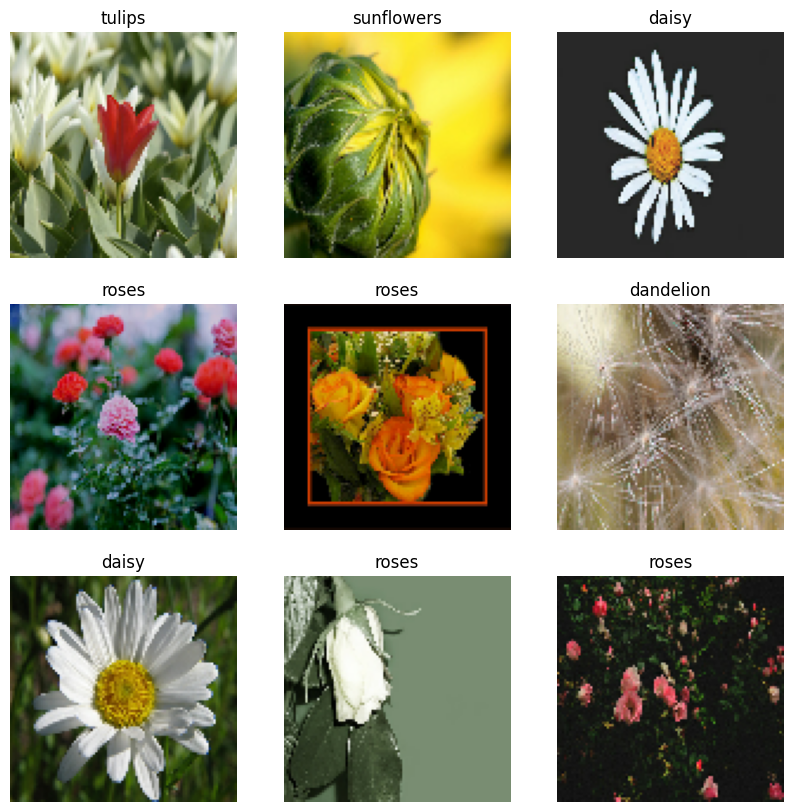

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

class_names = dataset.class_names
print (class_names)
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        class_idx = np.argmax(labels[i].numpy())  # Get the index from one-hot encoding
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[class_idx])  # Use the correct index to get the class name
        plt.axis("off")

### Rescale pixel values

This model expects pixel vaues in `[-1,1]`, but at this point, the pixel values in our images are in `[0-255]`. To rescale them, we use the preprocessing method included with the model.

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Build the Model

### Create the base model
We will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes.

We need to pick which layer of MobileNet V2 you will leverage as the high level features you wish to re-use. Since we want to adapt the classifications coming out of the model to a new task, we want to leverage the features coming out of the *last* layer BEFORE the classification layers.

In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               alpha=0.35,
                                               weights='imagenet')

2019640/2019640 [==============================] - 1s 1us/step


In [11]:
image_batch, label_batch = next(iter(train_datase
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 1280)


### Freeze the convolutional layers

It is important to freeze the convolutional layers before you compile and train the model with transfer learning. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. We want to perform this operation because we want to leverage the pre-trained values in the convolutional layers and only learn new classification layer values. We can do this by setting the entire model's `trainable` flag to False.

In [12]:
print (base_model.trainable)
base_model.trainable = False
print (base_model.trainable)


True
False


In [13]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_0.35_96"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 48, 48, 16)           432       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 48, 48, 16)           64        ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 48, 48, 16)           0         ['bn_Conv1[0

### Add a classification head

To begin the process of generating classifications from the pretrained features, we use a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the 3x3 spatial features into a single 1024-element feature vector per image.

In [14]:
classification_input_layer = tf.keras.layers.Flatten()
# classification_input_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average = classification_input_layer(feature_batch)
print(feature_batch_average.shape)

(32, 11520)


We then apply a `tf.keras.layers.Dense` layer to convert the feature vector into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [15]:
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


We can then build our final model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). Importantly we remind Tensorflow that we do not want to train the base_model!

In [16]:
inputs = tf.keras.Input(shape=(96, 96, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = classification_input_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it.

In [17]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 96, 96, 3)         0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 96, 96, 3)         0         
 da)                                                             
                                                                 
 mobilenetv2_0.35_96 (Funct  (None, 3, 3, 1280)        410208    
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                             

## Train and Evaluate the model


In [19]:
EPOCHS = 10
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])


Epoch 1/10
96/96 [==============================] - 39s 343ms/step - loss: 1.2088 - accuracy: 0.5674 - val_loss: 0.6979 - val_accuracy: 0.7461
Epoch 2/10
96/96 [==============================] - 23s 238ms/step - loss: 0.5793 - accuracy: 0.7995 - val_loss: 0.5798 - val_accuracy: 0.8026
Epoch 3/10
96/96 [==============================] - 23s 239ms/step - loss: 0.4332 - accuracy: 0.8398 - val_loss: 0.5154 - val_accuracy: 0.8263
Epoch 4/10
96/96 [==============================] - 23s 235ms/step - loss: 0.3441 - accuracy: 0.8848 - val_loss: 0.4743 - val_accuracy: 0.8421
Epoch 5/10
96/96 [==============================] - 24s 242ms/step - loss: 0.2754 - accuracy: 0.9030 - val_loss: 0.4539 - val_accuracy: 0.8539
Epoch 6/10
96/96 [==============================] - 24s 249ms/step - loss: 0.2406 - accuracy: 0.9173 - val_loss: 0.4206 - val_accuracy: 0.8566
Epoch 7/10
96/96 [==============================] - 32s 327ms/step - loss: 0.1906 - accuracy: 0.9417 - val_loss: 0.4314 - val_accuracy: 0.8539

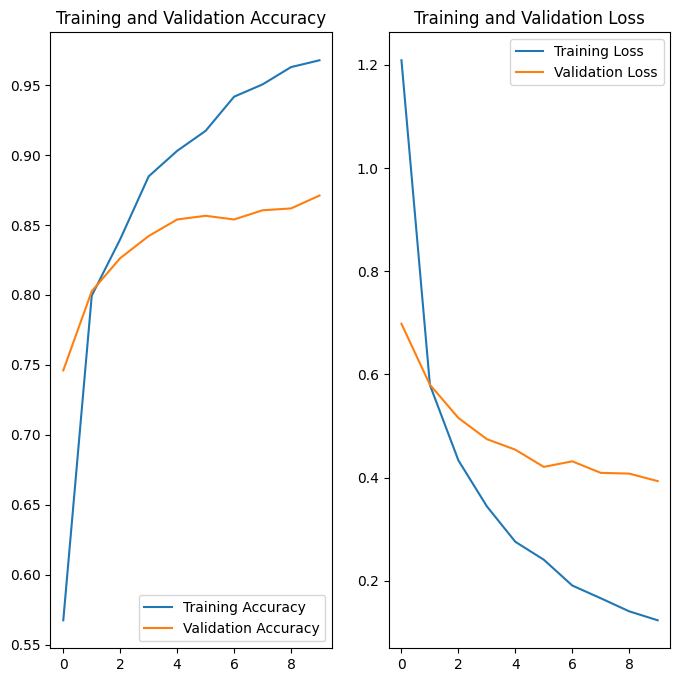

In [33]:
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# # plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Evaluate your model


In [21]:
loss, accuracy = model.evaluate(val_dataset)
print('Test accuracy :', accuracy)

24/24 [==============================] - 12s 102ms/step - loss: 0.3937 - accuracy: 0.8697
Test accuracy : 0.8697368502616882


Lets print the results from a bunch of the images in our test dataset!


Predictions (raw probabilities):
 [[4.92829308e-02 1.03598705e-03 9.21615422e-01 8.31084605e-03
  1.97548009e-02]
 [4.40710079e-04 9.99359310e-01 1.08558794e-04 3.54551485e-05
  5.59769105e-05]
 [6.56579738e-04 8.49214033e-04 1.77072361e-02 9.79567528e-01
  1.21941522e-03]
 [9.48372304e-01 5.47662703e-03 1.43876637e-03 7.97206350e-03
  3.67403477e-02]
 [1.12018482e-04 9.99453604e-01 3.03000183e-04 1.20350553e-04
  1.11194931e-05]
 [9.65702534e-01 2.95379087e-02 1.41521066e-03 7.74702639e-04
  2.56965356e-03]
 [9.80809093e-01 1.53231178e-03 5.69954063e-05 1.06256139e-02
  6.97604194e-03]
 [5.80297674e-05 2.31520506e-03 1.18102029e-03 9.95746434e-01
  6.99369819e-04]
 [1.86649795e-05 3.45073863e-06 2.28392033e-04 2.49396580e-05
  9.99724567e-01]
 [2.31765844e-05 9.99583304e-01 2.65446695e-04 1.12546077e-04
  1.55324160e-05]
 [6.28154430e-06 7.72795780e-03 3.19273227e-06 9.92262483e-01
  1.17972540e-07]
 [1.79811451e-03 1.02002285e-02 9.84041810e-01 5.43070564e-05
  3.90548655e-03]
 [1.99

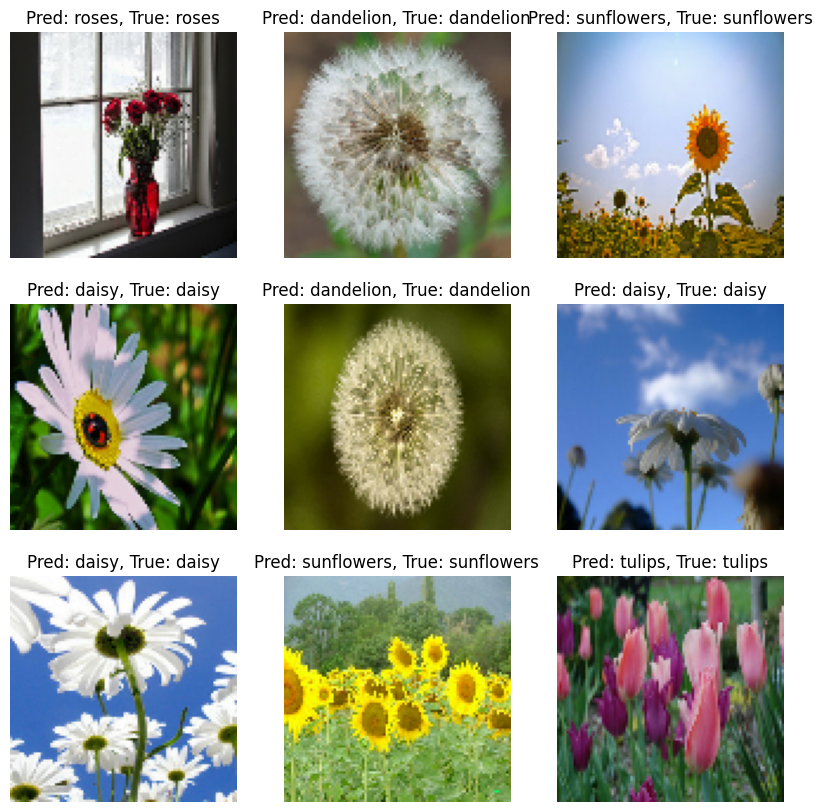

In [22]:
# Retrieve a batch of images from the validation set
image_batch, label_batch = val_dataset.as_numpy_iterator().next()

# Get predictions
predictions = model.predict_on_batch(image_batch)
print('Predictions (raw probabilities):\n', predictions)

# Convert predictions to class indices
predicted_class_indices = np.argmax(predictions, axis=1)
print('Predicted Class Indices:\n', predicted_class_indices)

# Convert true labels to class indices
true_class_indices = np.argmax(label_batch, axis=1)
print('True Class Indices:\n', true_class_indices)

# Visualize predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))

    predicted_class_idx = predicted_class_indices[i]
    true_class_idx = true_class_indices[i]

    plt.title(f"Pred: {class_names[predicted_class_idx]}, True: {class_names[true_class_idx]}")
    plt.axis("off")


In [23]:
### Save the model after training

# Specify the path where you want to save the model
# saved_model_path = 'model/my_trained_model.h5'  # For Keras model in H5 format
# For TensorFlow SavedModel format, use:
saved_model_path = 'model/saved_model'

# Save the model in the chosen format
model.save(saved_model_path)

print(f"Model saved at: {saved_model_path}")

Model saved at: model/saved_model


# Model conversion

## Original float model

In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT] # dynamic range quantization. size reduction but computing is done in fp32
tflite_model = converter.convert()

import pathlib
tflite_model_file = pathlib.Path('model/model-float32.tflite')
tflite_model_file.write_bytes(tflite_model)



596472

## Quantized model

In [25]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_data_get():
    for input_value, _ in val_dataset.take(100):
        yield [input_value]

converter.representative_dataset = representative_data_get
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_model_quant = converter.convert()
tflite_model_quant_file = pathlib.Path('model/model-int8.tflite')
tflite_model_quant_file.write_bytes(tflite_model_quant)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


671312

In [26]:
import os
import pathlib
import pandas as pd

# Define the function to get directory size (for the TensorFlow saved model)
def get_dir_size(dir):
    size = 0
    for f in os.scandir(dir):
        if f.is_file():
            size += f.stat().st_size
        elif f.is_dir():
            size += get_dir_size(f.path)
    return size

# Define paths to your model files
SAVED_MODEL_FILENAME = 'model/saved_model'  # Path to your original saved model
FLOAT_TFL_MODEL_FILENAME = 'model/model-float32.tflite'  # Path to the float32 TensorFlow Lite model
QUANTIZED_TFL_MODEL_FILENAME = 'model/model-int8.tflite'  # Path to the quantized TensorFlow Lite model

# Calculate sizes
size_tf = get_dir_size(SAVED_MODEL_FILENAME)  # Size of the original TensorFlow model
size_no_quant_tflite = os.path.getsize(FLOAT_TFL_MODEL_FILENAME)  # Size of the float32 TFLite model
size_tflite = os.path.getsize(QUANTIZED_TFL_MODEL_FILENAME)  # Size of the quantized TFLite model

# Prepare DataFrame to display results
size_comparison_df = pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite (Float32)", f"{size_no_quant_tflite} bytes", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite (Quantized Int8)", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
    columns = ["Model", "Size", "Reduction"], index="Model")

# Display the size comparison DataFrame
print(size_comparison_df)

                                           Size                   Reduction
Model                                                                      
TensorFlow                        5644847 bytes                            
TensorFlow Lite (Float32)          596472 bytes  (reduced by 5048375 bytes)
TensorFlow Lite (Quantized Int8)   671312 bytes   (reduced by -74840 bytes)


## Inference

In [27]:
image_batch, label_batch = val_dataset.as_numpy_iterator().next()
img = image_batch[0, :, :, :]
print(img.flatten())

# Write a C source file of the image for debugging purposes (to check if the model output is correct)
with open('src/img.h', 'w') as f:
    f.write('#ifndef IMG_TEST_DATA\n')
    f.write('#define IMG_TEST_DATA\n')
    f.write('const float img_data[] = {')
    for i, val in enumerate(img.flatten()):
        f.write(str(val))
        if i < len(img.flatten()) - 1:
            f.write(',')
    f.write('};\n')
    f.write('#endif\n')

[ 2.      4.      1.     ... 14.75   23.25    1.3125]


In [28]:
# Load and run the TFLite model
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

# Preprocess and run inference
interpreter.set_tensor(input_index, np.expand_dims(img, axis=0))
interpreter.invoke()
output = interpreter.get_tensor(output_index)

# Convert the output to class probabilities (if softmax is not applied in the model)
predictions = tf.nn.softmax(output).numpy()[0]  # Output probabilities for each class
predicted_class = np.argmax(predictions)  # Get the class with the highest probability

print(f"Predicted class: {predicted_class} ({class_names[predicted_class]})")
print(f"Class probabilities: {predictions}")

Predicted class: 1 (dandelion)
Class probabilities: [0.14908275 0.40366903 0.14908275 0.14908275 0.14908275]


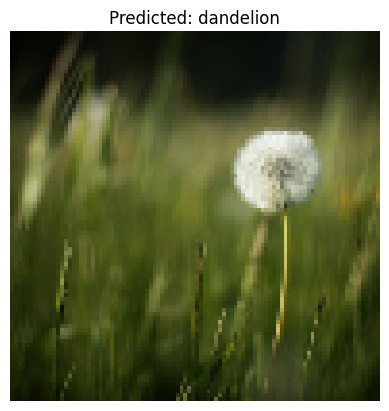

In [29]:
plt.imshow(img.astype("uint8"))
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.axis("off")
plt.show()

In [30]:
from tqdm import tqdm

def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    prediction_classes = []
    test_labels = []

    for test_images, test_labels_batch in tqdm(val_dataset):
        for i in range(len(test_labels_batch)):
            # Run inference on each image
            interpreter.set_tensor(input_index, np.expand_dims(test_images[i], axis=0))
            interpreter.invoke()
            output = interpreter.get_tensor(output_index)

            # Convert the output to class probabilities and get predicted class
            predictions = tf.nn.softmax(output).numpy()[0]
            predicted_class = np.argmax(predictions)
            prediction_classes.append(predicted_class)

            # Store the true label (convert from one-hot encoding if necessary)
            true_label = np.argmax(test_labels_batch[i])  # Adjust if using categorical labels
            test_labels.append(true_label)

    prediction_classes = np.array(prediction_classes)
    test_labels = np.array(test_labels)

    print("Sample Predictions:", prediction_classes[:10])
    print("Sample Labels:", test_labels[:10])

    accuracy = (prediction_classes == test_labels).mean()
    return accuracy

# Evaluate float model
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()
test_accuracy = evaluate_model(interpreter)
print('Float model accuracy =', test_accuracy)

# Evaluate quantized model
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter.allocate_tensors()
test_accuracy = evaluate_model(interpreter)
print('Quantized model accuracy =', test_accuracy)


100%|██████████| 24/24 [00:13<00:00,  1.74it/s]


Sample Predictions: [0 3 2 3 2 3 3 3 4 1]
Sample Labels: [0 3 2 3 2 3 3 3 4 1]
Float model accuracy = 0.8657894736842106


100%|██████████| 24/24 [00:13<00:00,  1.77it/s]

Sample Predictions: [2 3 0 2 4 2 3 1 4 0]
Sample Labels: [2 3 0 2 4 2 3 1 4 0]
Quantized model accuracy = 0.8342105263157895


## Generate model CC file

In [31]:
model_file = 'model-int8'
!xxd -i model/{model_file}.tflite | sed "s/unsigned/const unsigned/g" | sed "s/model_model_int8_tflite/gmodel/g"> src/model.cc
# !xxd -n gmodel -i model/{model_file}.tflite | sed "s/unsigned/const unsigned/g" > src/model.cc